In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
from scipy.optimize import minimize, fmin_cg
from IPython import display

## Load Data

$Y$ is the **ratings** matrix, $Y(i,j) \in \{0,1,2,3,4,5\}$

$R$ is the **rated status** matrix, $R(i,j) \in \{0,1\}$

$Y, R \in \mathbb{R}^{n_m \times n_u}$

In [3]:
data = loadmat('ex8_movies.mat')
Y, R = data['Y'].astype(float), data['R'].astype(float)

In [4]:
Y.shape, R.shape

((1682, 943), (1682, 943))

$X$ is the **movie features** matrix, $X \in \mathbb{R}^{n_m \times 10}$

$Theta$ is the **user parameters** matrix, $Theta \in \mathbb{R}^{n_u \times 10}$

In [5]:
n_features = 100
X = np.zeros((Y.shape[0], n_features))
Theta = np.zeros((Y.shape[1], n_features))

In [6]:
X.shape, Theta.shape

((1682, 100), (943, 100))

## Cost Function

$\displaystyle J(x^{(1)},\dots,x^{(n_m)},\theta^{(1)},\dots,\theta^{(n_u)}) = \frac{1}{2} \sum_{(i,j):r(i,j)=1} ((\theta^{(j)})^{\top} x^{(i)} - y^{(i,j)})^2 + \left(\frac{\lambda}{2}\sum_{j=1}^{n_u}\sum_{k=1}^{n}(\theta_{k}^{(j)})^2\right) + \left(\frac{\lambda}{2}\sum_{i=1}^{n_m}\sum_{k=1}^{n}(x_{k}^{(i)})^2\right)$

In [7]:
params = loadmat('ex8_movieParams.mat')
X, Theta = params['X'], params['Theta']

In [8]:
def cost(X_Theta, Y, R, n_movies, n_users, n_params, lamb=0):
    X = X_Theta[:n_movies*n_params].reshape((n_movies, n_params))
    Theta = X_Theta[n_movies*n_params:].reshape((n_users, n_params))
    X_reg = (lamb/2) * np.sum(X**2)
    Theta_reg = (lamb/2) * np.sum(Theta**2)
    return (np.sum(np.square(R * (X @ Theta.T - Y))) / 2) + X_reg + Theta_reg

In [9]:
def pack(*ts):
    return np.concatenate([np.ravel(t) for t in ts])

def unpack(p, *dims):
    data = []
    for i,j in dims:
        data.append(np.reshape(p[:i*j], (i,j)))
        p = p[i*j:]
    return data

In [10]:
c = cost(pack(X[:5,:3], Theta[:4,:3]), Y[:5,:4], R[:5,:4], 5, 4, 3)
print(f'The cost is {c:.2f}')

The cost is 22.22


In [11]:
c = cost(pack(X[:5,:3], Theta[:4,:3]), Y[:5,:4], R[:5,:4], 5, 4, 3, lamb=1.5)
print(f'The regularized cost is {c:.2f}')

The regularized cost is 31.34


In [12]:
cost(pack(X, Theta), Y, R, Y.shape[0], Y.shape[1], X.shape[1])

27918.64012454421

## Gradient Function

$\displaystyle \frac{\partial\,J}{\partial\,x_{k}^{(i)}} = \sum_{j:r(i,\,j)=1} ((\theta^{(j)})^{\top}x^{(i)}-y^{(i,\,j)})\theta_{k}^{(j)} + \lambda x_{k}^{(i)}$

$\displaystyle \frac{\partial\,J}{\partial\,\theta_{k}^{(j)}} = \sum_{i:r(i,\,j)=1} ((\theta^{(j)})^{\top}x^{(i)}-y^{(i,\,j)})x_{k}^{(i)} + \lambda \theta_{k}^{(j)}$

In [13]:
def gradient(X_Theta, Y, R, n_movies, n_users, n_params, lamb=0):
    X, Theta = unpack(X_Theta, (n_movies, n_params), (n_users, n_params))
    diffs = R * (X @ Theta.T - Y)
    X_reg = lamb * X
    Theta_reg = lamb * Theta
    X_grad = diffs @ Theta + X_reg
    Theta_grad = diffs.T @ X + Theta_reg
    return np.concatenate((X_grad.ravel(), Theta_grad.ravel()))

In [14]:
def numerical_gradient(X_Theta, Y, R, n_movies, n_users, n_params, lamb=0):
    gradients = np.zeros(len(X_Theta))
    t = np.zeros(len(X_Theta))
    eps = 1e-4
    for i in range(len(X_Theta)):
        t[i] = eps
        xt_high = X_Theta + t
        xt_low = X_Theta - t
        J_high = cost(xt_high, Y, R, n_movies, n_users, n_params, lamb)
        J_low = cost(xt_low, Y, R, n_movies, n_users, n_params, lamb)
        gradients[i] = (J_high - J_low)/ (2*eps)
        t[i] = 0
    return gradients

In [15]:
def test_gradient(X_Theta, Y, R, n_movies, n_users, n_params, lamb=0):
    g1 = gradient(X_Theta, Y, R, n_movies, n_users, n_params, lamb)
    g2 = numerical_gradient(X_Theta, Y, R, n_movies, n_users, n_params, lamb)
    rel_diff =  np.linalg.norm(g2-g1)/np.linalg.norm(g2+g1)
    print(f'The relative difference is about {rel_diff}.')

In [16]:
gradient(pack(X, Theta), Y, R, Y.shape[0], Y.shape[1], X.shape[1])

array([-6.26184144,  2.45936046, -6.87560329, ..., -6.56073746,
        5.20459188,  2.65003952])

In [83]:
test_gradient(pack(X, Theta), Y, R, Y.shape[0], Y.shape[1], X.shape[1])

The relative difference is about 4.370660707747889e-09.


In [17]:
n_movies = 10
n_users = 10
n_params = 10
X_Theta = pack(X[:n_movies,:n_params], Theta[:n_users,:n_params])
res = minimize(fun=cost,
               x0=X_Theta,
               args=(Y[:n_movies,:n_users],
                     R[:n_movies,:n_users],
                     n_movies,
                     n_users,
                     n_params),
               method='CG',
               jac=gradient,
               options={
                   'maxiter': 100
               })
print(res.success)
unpack(res.x, (n_movies, n_params), (n_users, n_params));

True


### Normalized Ratings

     fun: 38968.47482897758
     jac: array([-0.02976977,  0.04126618,  0.06262536, ..., -0.00537149,
        0.00737137,  0.01326238])
 message: 'Maximum number of iterations has been exceeded.'
    nfev: 150
     nit: 100
    njev: 150
  status: 1
 success: False
       x: array([ 0.55412079,  0.68870047,  0.13691496, ..., -0.28400072,
       -0.38315075,  0.61468118])


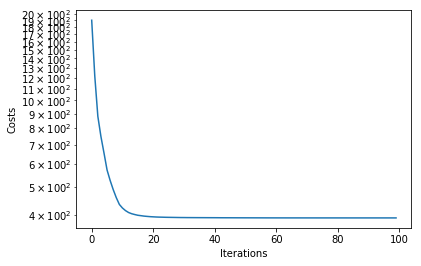

In [18]:
def gradient_descent(Y, R, n_movies, n_users, n_params, lamb=10, iterations=100):
    n_movies, n_users = Y.shape
    X_Theta = pack(np.random.randn(n_movies, n_params), np.random.randn(n_users, n_params))
    
    Y_mean = np.average(Y, axis=1, weights=R).reshape((-1,1))
    Y_norm = R * (Y - Y_mean)

    costs = []

    def iteration_cb(xk):
        c = cost(xk, Y_norm[:n_movies,:n_users],
             R[:n_movies,:n_users],
             n_movies, n_users, n_params, 10)
        costs.append(c)

    res = minimize(fun=cost,
                   x0=X_Theta,
                   args=(Y_norm,
                         R,
                         n_movies,
                         n_users,
                         n_params,
                         lamb),
                   method='CG',
                   jac=gradient,
                   options={
                       'maxiter': iterations
                   },
                   callback=iteration_cb)
    print(res)
    
    plt.plot(range(len(costs)), costs)
    plt.yscale('log', basey = 100)
    plt.xlabel('Iterations')
    plt.ylabel('Costs')
    # !!!try different values and choose minimum
    
    X_fit, Theta_fit = unpack(res.x, (n_movies, n_params), (n_users, n_params))
    return X_fit, Theta_fit

X_fit, Theta_fit = gradient_descent(Y, R, n_movies, n_users, n_params, lamb=10, iterations=100)

In [19]:
R * ((X_fit @ Theta_fit.T) + Y_mean)

NameError: name 'Y_mean' is not defined

In [62]:
movies = np.fromregex(file='movie_ids.txt',
             dtype=[('index', 'i4'), ('title', 'U20')],
             regexp=r'(\d+) (.*)',
             encoding='LATIN-1')